In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from src.models.train import train_single_model
from src.models.utils import milling_add_y_label_anomaly, get_model_metrics_df
from ast import literal_eval
from src.visualization.visualize import plot_pr_roc_curves_kfolds
%load_ext autoreload
%autoreload 2

/home/tvhahn/featstore/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
proj_dir = Path.cwd().parent.parent.parent
scratch_dir = Path.home() / "scratch"

In [3]:
df = pd.read_csv('compiled_results.csv',)
df = df[df['scaler_method'] == "minmax"].reset_index(drop=True)
df.head()

,uo_method,scaler_method,imbalance_ratio,classifier,sampler_seed,feat_col_list,date_time,dataset,id,precision_score_min,...,XGB_eval_metric,XGB_lambda,XGB_max_depth,XGB_objective,XGB_scale_pos_weight,XGB_seed,KNeighborsClassifier_metric,KNeighborsClassifier_n_neighbors,KNeighborsClassifier_weights,SVC_degree
0,NaN,minmax,0.5,lr,5661693,"['smcdc__kurtosis', 'smcac__kurtosis', 'vib_sp...",2022-05-06-1543-32,milling,5661693_lr_2022-05-06-1543-32_milling,0.109400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,adasyn,minmax,1.0,rf,22034022,"['smcdc__kurtosis', 'smcac__kurtosis', 'vib_sp...",2022-05-06-1543-32,milling,22034022_rf_2022-05-06-1543-32_milling,0.645498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,random_under,minmax,0.1,sgd,21155389,"['smcdc__kurtosis', 'smcac__kurtosis', 'vib_sp...",2022-05-06-1543-32,milling,21155389_sgd_2022-05-06-1543-32_milling,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,random_under_bootstrap,minmax,0.8,svm,17469775,"['smcdc__kurtosis', 'smcac__kurtosis', 'vib_sp...",2022-05-06-1543-32,milling,17469775_svm_2022-05-06-1543-32_milling,0.055307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,smote,minmax,1.0,rf,23707929,"['smcdc__kurtosis', 'smcac__kurtosis', 'vib_sp...",2022-05-06-1543-32,milling,23707929_rf_2022-05-06-1543-32_milling,0.649275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
mill_feature_path = scratch_dir / "feat-store" / "data/processed/milling/milling_features.csv.gz"
df_feat = pd.read_csv(mill_feature_path, compression='gzip')
df_feat = milling_add_y_label_anomaly(df_feat)
print(df_feat["y"].unique())
df_feat.head()

[0 1]


,cut_id,ae_spindle__length,ae_spindle__kurtosis,ae_table__length,ae_table__kurtosis,vib_spindle__length,vib_spindle__kurtosis,vib_table__length,vib_table__kurtosis,smcdc__length,smcdc__kurtosis,smcac__length,smcac__kurtosis,cut_no,case,tool_class,y
0,50_23,64.0,-0.536421,64.0,1.023564,64.0,0.052618,64.0,-1.182274,64.0,-0.741543,64.0,-1.379993,50,4,1,0
1,50_24,64.0,0.580646,64.0,-0.248433,64.0,-0.477432,64.0,-1.185010,64.0,-0.906486,64.0,-1.373383,50,4,1,0
2,50_25,64.0,-0.335575,64.0,-0.117931,64.0,0.385026,64.0,-1.320485,64.0,-1.051426,64.0,-1.398157,50,4,1,0
3,50_26,64.0,-1.180998,64.0,-0.227941,64.0,0.198078,64.0,-1.123297,64.0,-0.680110,64.0,-1.348922,50,4,1,0
4,50_27,64.0,-0.074406,64.0,-0.431231,64.0,-0.430192,64.0,-1.300146,64.0,-0.387458,64.0,-1.363613,50,4,1,0


In [13]:
def rebuild_params_clf(df, row_idx):
    classifier_string = df.iloc[row_idx]['classifier']
    if classifier_string == "rf":
        prefix = 'RandomForestClassifier'

    elif classifier_string == "xgb":
        prefix = 'XGB'

    elif classifier_string == "knn":
        prefix = 'KNeighborsClassifier'

    elif classifier_string == "lr":
        prefix = 'LogisticRegression'

    elif classifier_string == "sgd":
        prefix = 'SGDClassifier'

    elif classifier_string == "ridge":
        prefix = 'RidgeClassifier'

    elif classifier_string == "svm":
        prefix = 'SVC'

    elif classifier_string == "nb":
        prefix = 'GaussianNB'

    params_clf = {c.replace(f"{prefix}_",""): df.iloc[row_idx][c]  for c in df.iloc[row_idx].dropna().index if c.startswith(prefix)}

    # convert any whole numbers in clf_cols to int
    for k in params_clf.keys():
        if isinstance(params_clf[k], float) and params_clf[k].is_integer():
            params_clf[k] = int(params_clf[k])

    return {k: [params_clf[k]] for k in params_clf.keys()} # put each value in a list

def rebuild_general_params(df, row_idx, general_param_keys=None):
    if general_param_keys is None:
        general_param_keys = ['scaler_method', 'uo_method', 'imbalance_ratio', 'classifier']
    return {k: [df.iloc[row_idx][k]] for k in general_param_keys}    

In [35]:
row_idx = 0

params_clf = rebuild_params_clf(df, row_idx)
print(params_clf)

general_params = rebuild_general_params(df, row_idx)
print(general_params)

meta_label_cols = ["cut_id", "cut_no", "case", "tool_class"]
stratification_grouping_col = "cut_no"
y_label_col = "y"
feat_selection = True
feat_col_list = literal_eval(df.iloc[row_idx]["feat_col_list"])
sampler_seed = int(df.iloc[row_idx]["sampler_seed"])
print(sampler_seed)

(
    model_metrics_dict,
    params_dict_clf_named,
    params_dict_train_setup,
    feat_col_list
) = train_single_model(
    df_feat,
    sampler_seed,
    meta_label_cols,
    stratification_grouping_col,
    y_label_col,
    feat_selection,
    feat_col_list,
    general_params=general_params,
    params_clf=params_clf,
)

{'class_weight': ['balanced'], 'max_iter': [20000], 'penalty': ['none'], 'solver': ['lbfgs']}
{'scaler_method': ['minmax'], 'uo_method': [nan], 'imbalance_ratio': [0.5], 'classifier': ['lr']}
5661693
classifier: lr, uo_method: nan, imbalance_ratio: 0.5

 {'LogisticRegression_solver': 'lbfgs', 'LogisticRegression_penalty': 'none', 'LogisticRegression_max_iter': 20000, 'LogisticRegression_class_weight': 'balanced', 'LogisticRegression_l1_ratio': None}
0
scaling - min/max
min x_train 0.0
max x_train 1.0
min x_test 0.0
max x_test 1.0
x_train shape: (9232, 5)
1
scaling - min/max
min x_train 0.0
max x_train 1.0
min x_test 0.0
max x_test 1.0
x_train shape: (9254, 5)
2
scaling - min/max
min x_train 0.0
max x_train 1.0
min x_test 0.0
max x_test 1.0
x_train shape: (9220, 5)
3
scaling - min/max
min x_train 0.0
max x_train 1.0
min x_test 0.0
max x_test 1.0
x_train shape: (9224, 5)
4
scaling - min/max
min x_train 0.0
max x_train 1.0
min x_test 0.0
max x_test 1.0
x_train shape: (9350, 5)


In [36]:
params_dict_train_setup

{'uo_method': nan,
 'scaler_method': 'minmax',
 'imbalance_ratio': 0.5,
 'classifier': 'lr',
 'sampler_seed': 5661693}

In [37]:
dfr = get_model_metrics_df(model_metrics_dict)
cols_select = list(dfr.columns)
dfr

,precision_score_min,precision_score_max,precision_score_avg,precision_score_std,recall_score_min,recall_score_max,recall_score_avg,recall_score_std,f1_score_min,f1_score_max,...,prauc_min,prauc_max,prauc_avg,prauc_std,accuracy_min,accuracy_max,accuracy_avg,accuracy_std,n_thresholds_min,n_thresholds_max
0,0.1094,0.158302,0.130668,0.015966,0.650869,0.736311,0.68262,0.029117,0.187315,0.260581,...,0.116102,0.171166,0.138271,0.019859,0.609682,0.685875,0.642931,0.027579,9220.0,9350.0


In [38]:
df[cols_select][row_idx:row_idx+1]

,precision_score_min,precision_score_max,precision_score_avg,precision_score_std,recall_score_min,recall_score_max,recall_score_avg,recall_score_std,f1_score_min,f1_score_max,...,prauc_min,prauc_max,prauc_avg,prauc_std,accuracy_min,accuracy_max,accuracy_avg,accuracy_std,n_thresholds_min,n_thresholds_max
0,0.1094,0.158302,0.130668,0.015966,0.650869,0.736311,0.68262,0.029117,0.187315,0.260581,...,0.116102,0.171166,0.138271,0.019859,0.609682,0.685875,0.642931,0.027579,9220.0,9350.0


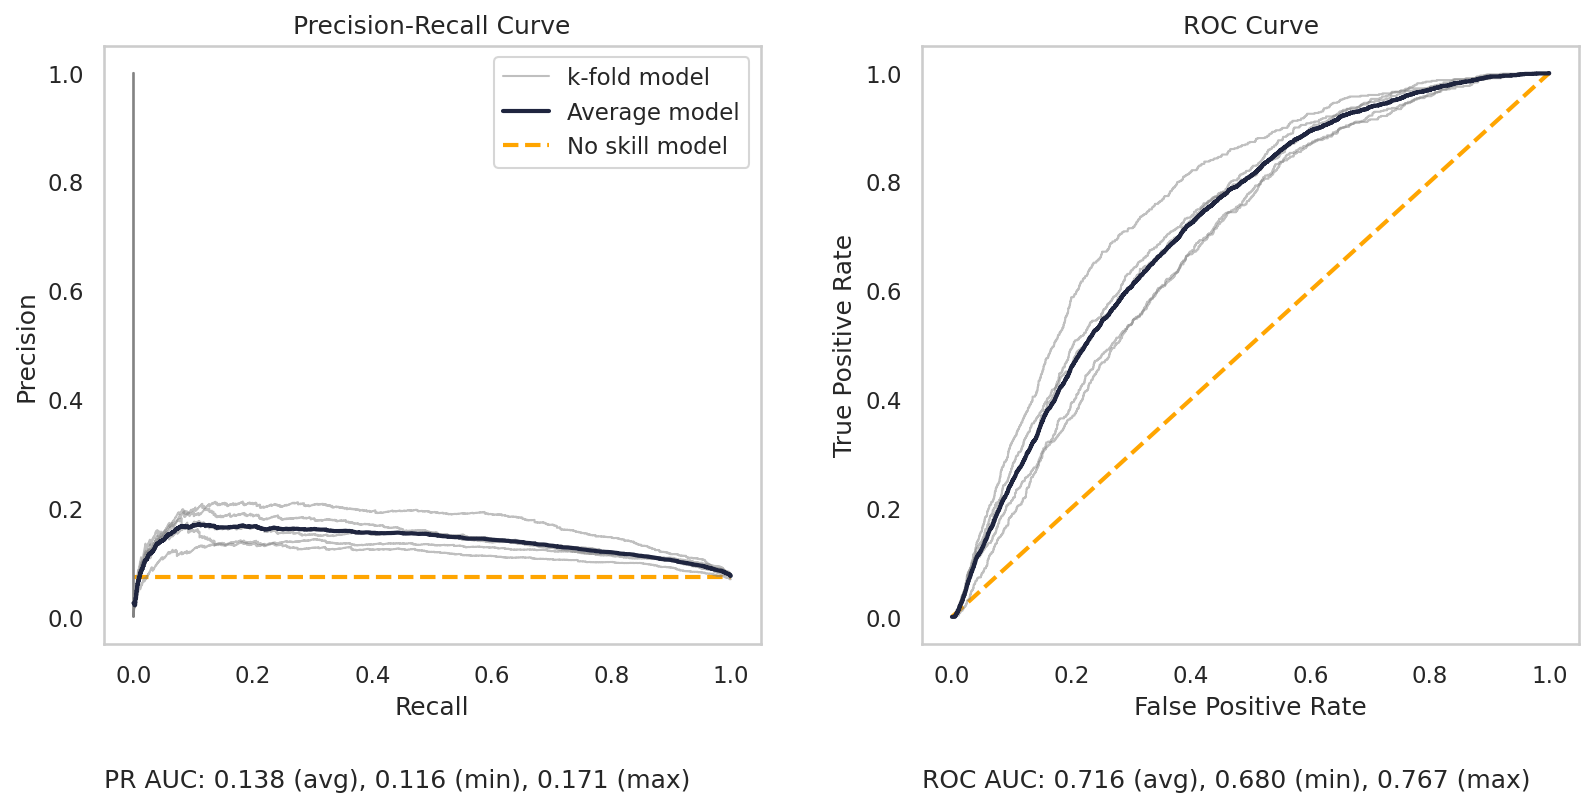

In [39]:
plot_pr_roc_curves_kfolds(
    model_metrics_dict["precisions_array"],
    model_metrics_dict["recalls_array"],
    model_metrics_dict["fpr_array"],
    model_metrics_dict["tpr_array"],
    model_metrics_dict["rocauc_array"],
    model_metrics_dict["prauc_array"],
    percent_anomalies_truth=0.073,
)

In [47]:
print(df.iloc[row_idx]["prauc_avg"])
print(df.iloc[row_idx]["prauc_min"])
print(df.iloc[row_idx]["rocauc_avg"])

0.113482585
0.100452925
0.659100636


In [39]:
df.iloc[row_idx].index

Index(['uo_method', 'scaler_method', 'imbalance_ratio', 'classifier',
       'sampler_seed', 'feat_col_list', 'date_time', 'dataset',
       'precision_score_min', 'precision_score_max', 'precision_score_avg',
       'precision_score_std', 'recall_score_min', 'recall_score_max',
       'recall_score_avg', 'recall_score_std', 'f1_score_min', 'f1_score_max',
       'f1_score_avg', 'f1_score_std', 'rocauc_min', 'rocauc_max',
       'rocauc_avg', 'rocauc_std', 'prauc_min', 'prauc_max', 'prauc_avg',
       'prauc_std', 'accuracy_min', 'accuracy_max', 'accuracy_avg',
       'accuracy_std', 'n_thresholds_min', 'n_thresholds_max', 'SVC_C',
       'SVC_kernel', 'SVC_max_iter', 'SVC_verbose', 'RidgeClassifier_alpha',
       'XGB_alpha', 'XGB_eta', 'XGB_eval_metric', 'XGB_lambda',
       'XGB_max_depth', 'XGB_objective', 'XGB_scale_pos_weight', 'XGB_seed',
       'KNeighborsClassifier_metric', 'KNeighborsClassifier_n_neighbors',
       'KNeighborsClassifier_weights', 'LogisticRegression_class_wei

# Scratch

In [6]:
from src.models.random_search_setup import (
    rf_params,
    xgb_params,
    knn_params,
    lr_params,
    sgd_params,
    ridge_params,
    svm_params,
    nb_params,
    general_params
)

general_params.keys()

dict_keys(['scaler_method', 'uo_method', 'imbalance_ratio', 'classifier'])

In [7]:
general_params_single = {}
for k in general_params.keys():
    general_params_single[k] = [df.iloc[0][k]]

In [8]:
# make a dict comprehension for general_params_single
general_params_single = {k: [df.iloc[0][k]] for k in general_params.keys()}
general_params_single

{'scaler_method': ['minmax'],
 'uo_method': ['smote'],
 'imbalance_ratio': [0.5],
 'classifier': ['svm']}

In [9]:
# find all columns in df that begin with "RandomForestClassifier"
prestring = 'RandomForestClassifier'
clf_cols = {c.replace(f"{prestring}_",""): df.iloc[0][c]  for c in df.iloc[0].dropna().index if c.startswith(prestring)}
clf_cols

{}

In [10]:
# convert any whole numbers in clf_cols to int
for k in clf_cols.keys():
    if isinstance(clf_cols[k], float) and clf_cols[k].is_integer():
        clf_cols[k] = int(clf_cols[k])


In [11]:
clf_cols

{}

In [13]:
params_clf = rebuild_params_clf(df, 0)
params_clf

{'C': [1.31], 'kernel': ['sigmoid'], 'max_iter': [25000], 'verbose': [False]}